# Investigating Fandago Movie Ratings
## Context
Fandango is an online movie ratings aggregator. In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased. He was able to find that:
- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.

## Project goals
Fandango's officials replied that the biased rounding off was caused by a bug in their system, and they promised to fix the bug as soon as possible. In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

## Data description
- Hickey's data previous to his analysis:
https://github.com/fivethirtyeight/data/tree/master/fandango
- Movie ratings in 2016 and 2017 scrapped by Micre Alex:
https://github.com/mircealex/Movie_ratings_2016_17

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')
fandango = pd.read_csv('fandango_score_comparison.csv')
ratings = pd.read_csv('movie_ratings_16_17.csv')

## Overview

In [19]:
fandango.info()
fandango.columns
fandango[:3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
FILM                          146 non-null object
RottenTomatoes                146 non-null int64
RottenTomatoes_User           146 non-null int64
Metacritic                    146 non-null int64
Metacritic_User               146 non-null float64
IMDB                          146 non-null float64
Fandango_Stars                146 non-null float64
Fandango_Ratingvalue          146 non-null float64
RT_norm                       146 non-null float64
RT_user_norm                  146 non-null float64
Metacritic_norm               146 non-null float64
Metacritic_user_nom           146 non-null float64
IMDB_norm                     146 non-null float64
RT_norm_round                 146 non-null float64
RT_user_norm_round            146 non-null float64
Metacritic_norm_round         146 non-null float64
Metacritic_user_norm_round    146 non-null float64
IMDB_norm_round               146 n

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5


In [20]:
ratings.info()
ratings.columns
ratings[:3]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
movie           214 non-null object
year            214 non-null int64
metascore       214 non-null int64
imdb            214 non-null float64
tmeter          214 non-null int64
audience        214 non-null int64
fandango        214 non-null float64
n_metascore     214 non-null float64
n_imdb          214 non-null float64
n_tmeter        214 non-null float64
n_audience      214 non-null float64
nr_metascore    214 non-null float64
nr_imdb         214 non-null float64
nr_tmeter       214 non-null float64
nr_audience     214 non-null float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.5,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.0,2.35,2.5,3.5,2.0,2.5


- There are more columns than needed to investigate on Fandango's rating. Let's drop these.
- fandago dataset do not have 'year' column but instead putting them in 'FILM' column, let's sanitize that

In [29]:
f_before['Year'] = f_before['FILM'].str[-5:-1]

In [22]:
f_before = fandango[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
f_after = ratings[['movie', 'year', 'fandango']].copy()

## Understanding the data
Our desired data is a sample that represent all movies has been released before and after Hickey's analysis. However, README.md of both dataset show that both authors only sample popular movies which cannot be representative. In order to continue, we change the goal of this project into analysis Fandango popular movie ratings from 2015 and 2016.

## Verify sample movie popularity
While f_before stated that their criteria for movie popularity is more than 30 ratings, f_after dataset do not provide information on number of votings so we have to check them manually. Let's get a random sample first.

In [23]:
f_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


Checking these movies on Fandango gives us the following result:

- Mechanic: Resurrection:	2247
- Warcraft: 7271
- Max Steel:	493
- Me Before You:	5263
- Fantastic Beasts and Where to Find Them: 13400
- Cell: 17
- Genius:	127
- Sully: 11877
- A Hologram for the King: 500
- Captain America: Civil War:	35057

90% of the movies has more than 30 fan ratings, that is enough for our sample. Let's move on and devide our movies into group of 2015 and 2016.

In [28]:
f_before['Year'] = f_before['FILM'].str[-5:-1]
f_2015 = f_before[f_before.Year == '2015']
f_2016 = f_after[f_after.year == 2016]

## Comparing Fandango ratings for popular movies between 2015 and 2016
The best way to compare trend and distribution for 2 datasets would be kernel density plots.

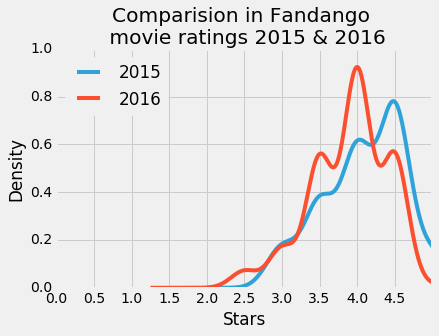

In [30]:
f_2015['Fandango_Stars'].plot.kde(title='Comparision in Fandango \n movie ratings 2015 & 2016',label='2015', legend=True)
f_2016['fandango'].plot.kde(label='2016',legend=True)
plt.xlabel('Stars')
plt.xlim(0,5)
plt.xticks(arange(0,5,0.5))
plt.show()

From above, we can conclude that:
- Both distributions are different from each other
- 2015 distribution seems to be more left skewed
- We can not tell for sure which data is more positive compare to the other
Let's try with some thing concrete such as summary statistics: comparing mean, median and mode

In [41]:
mean_2015 = f_2015['Fandango_Stars'].mean()
median_2015 = f_2015['Fandango_Stars'].median()
mode_2015 = f_2015['Fandango_Stars'].mode()[0]
mean_2016 = f_2016['fandango'].mean()
median_2016 = f_2016['fandango'].median()
mode_2016 = f_2016['fandango'].mode()[0]
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['Mean', 'Median', 'Mode']
summary

,2015,2016
Mean,4.085271,3.887435
Median,4.000000,4.000000
Mode,4.500000,4.000000


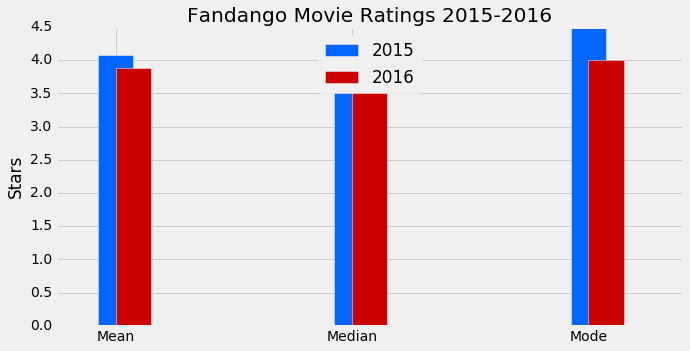

In [42]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(title='Fandango Movie Ratings 2015-2016', color='#0066FF', figsize=(10,5), align='center', label='2015', width=.15, rot=0)
summary['2016'].plot.bar(color = '#CC0000', align='edge', label='2016', width=.15, rot=0)
plt.ylabel('Stars')
plt.legend(loc='upper center')
plt.show()

## Conclusion
It is clear that 2015 ratings is higher than that of 2016. We can now conclude that Fandando have changed their ratings system to be stricter. Perhaps that was due to Hickey's article.